### Step 1: Data Preparation
#### Combine the relevant features from the Customers.csv and Transactions.csv datasets.
#### Perform feature scaling (normalization or standardization) to ensure clustering performance is not affected by varying scales.
### Step 2: Choose a Clustering Algorithm
#### Use K-Means for simplicity and ease of evaluation.
#### Optionally, you can explore DBSCAN, Hierarchical Clustering, or other methods.
### Step 3: Determine the Optimal Number of Clusters
#### Use the Elbow Method or Silhouette Analysis to determine the optimal number of clusters.
### Step 4: Evaluate Clustering
#### Compute the Davies-Bouldin (DB) Index and other metrics to assess clustering quality.
### Step 5: Visualize Clusters
#### Use 2D or 3D scatter plots or bar charts to visualize clusters

In [55]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler ,LabelEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:

# Step 1: Load Datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
df = transactions.merge(customers, on="CustomerID", how="inner")
df = df.merge(products, on="ProductID", how="inner")


In [57]:
df.head(0)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y


In [58]:
df.dtypes

TransactionID       object
CustomerID          object
ProductID           object
TransactionDate     object
Quantity             int64
TotalValue         float64
Price_x            float64
CustomerName        object
Region              object
SignupDate          object
ProductName         object
Category            object
Price_y            float64
dtype: object

In [59]:

# Step 2: Feature Engineering
# Calculate days since signup
df['SignupDate'] = pd.to_datetime(df['SignupDate'])
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['DaysSinceSignup'] = (df['TransactionDate'] - df['SignupDate']).dt.days

# Calculate recency (days since last transaction)
current_date = df['TransactionDate'].max()
df['DaysSinceLastTransaction'] = (current_date - df['TransactionDate']).dt.days



In [60]:
# Aggregate features per customer
customer_features = df.groupby('CustomerID').agg({
    'TotalValue': 'sum',             # Total spending
    'TransactionID': 'count',        # Number of transactions
    'ProductID': 'nunique',          # Unique products purchased
    'Price_x': 'mean',               # Average price per transaction
    'DaysSinceSignup': 'max',        # Days since signup
    'DaysSinceLastTransaction': 'min',  # Recency
    'Region': 'first',               # Customer region
    'Category': lambda x: x.value_counts().idxmax()  # Most frequent category
}).reset_index()



In [30]:

# Encode categorical features
label_encoder = LabelEncoder()
customer_features['Region'] = label_encoder.fit_transform(customer_features['Region'])
customer_features['Category'] = label_encoder.fit_transform(customer_features['Category'])


In [31]:

# Step 3: Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))


C:\Users\acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment v

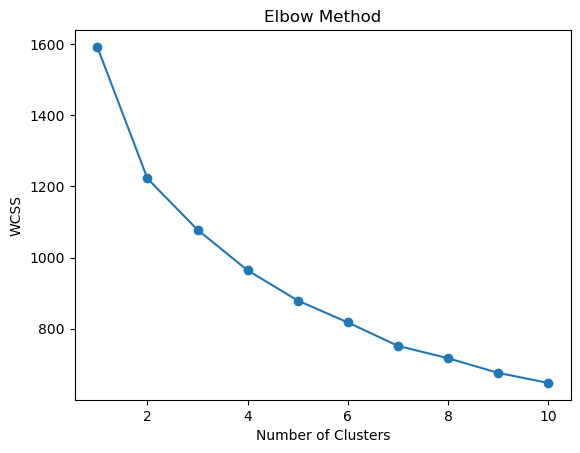

In [32]:
# Step 4: Determine Optimal Number of Clusters
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [50]:
# Step 5: Perform K-Means Clustering
optimal_clusters = 3  # Replace with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)



C:\Users\acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [51]:
# Step 6: Evaluate Clustering
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
silhouette_avg = silhouette_score(scaled_features, customer_features['Cluster'])

print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")



Davies-Bouldin Index: 1.614
Silhouette Score: 0.187


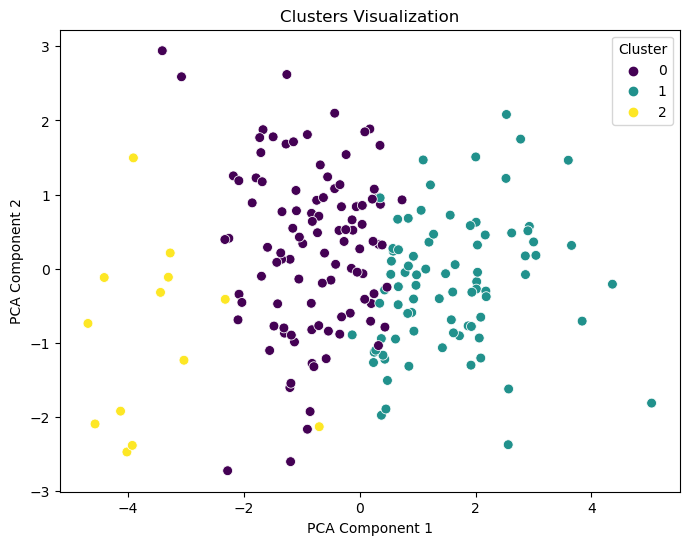

In [52]:
# Step 7: Visualize Clusters
# Reduce dimensions for visualization using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced_features[:, 0], y=reduced_features[:, 1], 
    hue=customer_features['Cluster'], palette='viridis', s=50
)
plt.title('Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()



In [53]:
# Step 8: Summarize Clusters
cluster_summary = customer_features.groupby('Cluster').agg({
    'TotalValue': ['mean', 'sum'],
    'TransactionID': 'mean',
    'ProductID': 'mean',
    'DaysSinceSignup': 'mean',
    'DaysSinceLastTransaction': 'mean',
    'Region': lambda x: label_encoder.inverse_transform([int(x.mode().iloc[0])])[0] if not x.mode().empty else 'Unknown',
    'Category': lambda x: label_encoder.inverse_transform([int(x.mode().iloc[0])])[0] if not x.mode().empty else 'Unknown'
})
cluster_summary


TotalValue            TransactionID ProductID DaysSinceSignup  \
                mean        sum          mean      mean            mean   
Cluster                                                                   
0        2498.471538  259841.04      3.836538  3.769231      499.519231   
1        5073.124512  415996.21      7.073171  6.841463      453.829268   
2        1089.100769   14158.31      1.615385  1.615385       85.692308   

        DaysSinceLastTransaction      Region     Category  
                            mean    <lambda>     <lambda>  
Cluster                                                    
0                      64.201923    Clothing   Home Decor  
1                      54.829268  Home Decor  Electronics  
2                     271.615385       Books   Home Decor